# 1. Data Cleaning

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#drop cols that contain irrelevant information or leak future information
cols_to_drop = ["Id", "MoSold", "SaleCondition", "SaleType", "YrSold", 'GarageYrBlt','YearBuilt','YearRemodAdd']


train['yr_built_to_sold'] = train['YrSold'] - train['YearBuilt']
train['yr_rem_to_sold'] = train['YrSold'] - train['YearRemodAdd']
test['yr_built_to_sold'] = test['YrSold'] - test['YearBuilt']
test['yr_rem_to_sold'] = test['YrSold'] - test['YearRemodAdd']

train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

nul_cols = (train.isnull().sum())

#drop columns that contain null values in their majority
train = train.drop(['Alley','PoolQC','Fence','MiscFeature'], axis=1)
test = test.drop(['Alley','PoolQC','Fence','MiscFeature'], axis=1)

#handling null values
nul_cols = (train.isnull().sum())

cols_to_fix = nul_cols[nul_cols > 0]

object_cols = train[cols_to_fix.index].select_dtypes(include=['object']).columns

object_cols = object_cols.drop('FireplaceQu')
for col in object_cols:
    mode = train[col].mode()
    train[col] = train[col].fillna(mode.iloc[0])
    
train['FireplaceQu'] = train['FireplaceQu'].fillna('NA')
num_cols = train[cols_to_fix.index].select_dtypes(include=['float64']).columns

#train['LotFrontage'] = train['LotFrontage'].fillna(train['LotFrontage'].mean())
#train['MasVnrArea'] = train['MasVnrArea'].fillna(train['MasVnrArea'].median())
#train['GarageYrBlt'] = train['GarageYrBlt'].fillna(train['GarageYrBlt'].mode().iloc[0])


train['LotFrontage'] = train['LotFrontage'].fillna(train['LotFrontage'].mode().iloc[0])
train['MasVnrArea'] = train['MasVnrArea'].fillna(train['MasVnrArea'].mode().iloc[0])

train['MSSubClass'] = train['MSSubClass'].astype('category')

# 2. Feature Engineering

In [80]:
num_cols = train.select_dtypes(include=['float64','int64']).columns
obj_cols = train.select_dtypes(include=['object']).columns

In [81]:
#train[num_cols].info()

#### rmse with all numeric values without transformation: 37,531

In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

features = num_cols.drop('SalePrice')

X, x, Y, y = train_test_split(train[features],train['SalePrice'], test_size = 0.2,random_state=1)


lr = LinearRegression()
lr.fit(X,Y)
predictions = lr.predict(x)

mse = mean_squared_error(predictions,y)
mse**(1/2)

37531.659137504525

## 2.1 Outliers (numeric cols)

In [83]:
import numpy as np
import matplotlib.pyplot as plt

anomalies = []

# Function to Detection Outlier on one-dimentional datasets.
def find_anomalies(col):
    # Set upper and lower limit to 3 standard deviation
    data_std = col.std()
    data_mean = col.mean()
    anomaly_cut_off = data_std * 3
    
    lower_limit  = data_mean - anomaly_cut_off 
    upper_limit = data_mean + anomaly_cut_off
    #print(lower_limit)
    #print(upper_limit)
    # Generate outliers
    for outlier in col:
        if type(outlier) != str:
            if outlier > upper_limit or outlier < lower_limit:
                anomalies.append(outlier)
    return anomalies

d = {}
for col in num_cols:
    anomalies = []
    d[col] = find_anomalies(train[col])

In [84]:
train.shape

(1460, 71)

In [85]:
for k,v in d.items():
    train = train[~train[k].isin(v)]
    
train.shape

(1023, 71)

#### rmse after removal of outliers: 19,784

In [86]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

features = num_cols.drop('SalePrice')

X, x, Y, y = train_test_split(train[features],train['SalePrice'], test_size = 0.2,random_state=1)


lr = LinearRegression()
lr.fit(X,Y)
predictions = lr.predict(x)

mse = mean_squared_error(predictions,y)
mse**(1/2)

19784.879046521553

## 2.2 Working on columns

### 2.2.1 1stFlrSF, 2ndFlrSF, GrLivArea

In [87]:
train[['1stFlrSF','2ndFlrSF','GrLivArea']]

,1stFlrSF,2ndFlrSF,GrLivArea
0,856,854,1710
2,920,866,1786
4,1145,1053,2198
6,1694,0,1694
10,1040,0,1040
...,...,...,...
1452,1072,0,1072
1453,1140,0,1140
1454,1221,0,1221
1455,953,694,1647


GrLivArea is the total of 1stFlrSF and 2ndFlrSF. We will remove the floor columns, and add a new column to indicate the number of floors each property has

In [88]:
train['n_floors'] = train['2ndFlrSF'].apply(lambda x: 2 if x > 0 else 1)

In [89]:
train = train.drop(['1stFlrSF','2ndFlrSF'], axis=1)

### 2.2.2 Bathrooms

In [90]:
bath_cols = ['BsmtFullBath','FullBath','BsmtHalfBath','HalfBath']
train['n_baths'] = train['BsmtFullBath'] + train['FullBath'] + (train['BsmtHalfBath']/2) + (train['HalfBath']/2)
#train[['BsmtFullBath','FullBath','BsmtHalfBath','HalfBath','n_baths']]
train = train.drop(bath_cols, axis=1)

### 2.2.3 Porch

In [91]:
porch_cols = ['OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']

porch_d = {}
for col in porch_cols:
    porch_d[col] = train[train[col] != 0].shape[0]

porch_d

{'OpenPorchSF': 571, 'EnclosedPorch': 125, '3SsnPorch': 1, 'ScreenPorch': 45}

Let's just add a column with total sum and remove these columns

In [92]:
train['porch_area'] = train[porch_cols].sum(axis=1)
train = train.drop(porch_cols, axis=1)

### 2.2.4 MiscVal, MiscFeature

In [93]:
misc_cols = ['MiscVal'] #miscfeature was already dropped
train[train['MiscVal']!=0].shape[0]

26

Only 26 rows contain info, so we will also drop MiscVal

In [94]:
train = train.drop(misc_cols,axis=1)

### 2.2.5 Exteriors

In [95]:
ext_cols = ['Exterior1st','Exterior2nd']
train['Exterior2nd'] = train['Exterior2nd'].replace('CmentBd', 'CemntBd')
filter = train['Exterior1st'] != train['Exterior2nd']
train[filter][['Exterior1st','Exterior2nd']].shape[0]

104

We'll drop Exterior2nd as there are only 104 different values

In [96]:
train = train.drop('Exterior2nd', axis = 1)

### 2.2.6 Basement

In [97]:
bsmnt_cols = ['BsmtFinType1','BsmtFinType2','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']
train[bsmnt_cols]

,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
0,GLQ,Unf,706,0,150,856
2,GLQ,Unf,486,0,434,920
4,GLQ,Unf,655,0,490,1145
6,GLQ,Unf,1369,0,317,1686
10,Rec,Unf,906,0,134,1040
...,...,...,...,...,...,...
1452,GLQ,Unf,547,0,0,547
1453,Unf,Unf,0,0,1140,1140
1454,GLQ,Unf,410,0,811,1221
1455,Unf,Unf,0,0,953,953


#### Converting to dummies

In [98]:
bsm_dum = pd.get_dummies(train[bsmnt_cols])
bsm_dum

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf
0,706,0,150,856,0,0,1,0,0,0,0,0,0,0,0,1
2,486,0,434,920,0,0,1,0,0,0,0,0,0,0,0,1
4,655,0,490,1145,0,0,1,0,0,0,0,0,0,0,0,1
6,1369,0,317,1686,0,0,1,0,0,0,0,0,0,0,0,1
10,906,0,134,1040,0,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452,547,0,0,547,0,0,1,0,0,0,0,0,0,0,0,1
1453,0,0,1140,1140,0,0,0,0,0,1,0,0,0,0,0,1
1454,410,0,811,1221,0,0,1,0,0,0,0,0,0,0,0,1
1455,0,0,953,953,0,0,0,0,0,1,0,0,0,0,0,1


#### For each type of basement, we will replace 1 with the total of the finished area

In [99]:
type1 = ['BsmtFinType1_ALQ', 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ',
       'BsmtFinType1_LwQ', 'BsmtFinType1_Rec', 'BsmtFinType1_Unf']
type2 = ['BsmtFinType2_ALQ', 'BsmtFinType2_BLQ', 'BsmtFinType2_GLQ',
       'BsmtFinType2_LwQ', 'BsmtFinType2_Rec', 'BsmtFinType2_Unf']

for i in range(len(bsm_dum)):
    for col in type1:
        if bsm_dum[col].iloc[i] == 1:
            bsm_dum[col].iloc[i] = bsm_dum['BsmtFinSF1'].iloc[i]
    for col in type2:
        if bsm_dum[col].iloc[i] == 1:
            bsm_dum[col].iloc[i] = bsm_dum['BsmtFinSF2'].iloc[i]

In [100]:
bsm_dum.head()

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf
0,706,0,150,856,0,0,706,0,0,0,0,0,0,0,0,0
2,486,0,434,920,0,0,486,0,0,0,0,0,0,0,0,0
4,655,0,490,1145,0,0,655,0,0,0,0,0,0,0,0,0
6,1369,0,317,1686,0,0,1369,0,0,0,0,0,0,0,0,0
10,906,0,134,1040,0,0,0,0,906,0,0,0,0,0,0,0


#### We will keep a column with the total area unfinished, and will drop the converted columns, the total area of the basement, and the ones with unifinished status

In [101]:
bsmnt_drop = ['BsmtFinSF1','BsmtFinSF2','TotalBsmtSF','BsmtFinType1_Unf','BsmtFinType2_Unf']

In [102]:
train = train.drop(bsmnt_cols, axis = 1)
train = pd.concat([train, bsm_dum], axis = 1)
train = train.drop(bsmnt_drop, axis=1)

In [103]:
num_cols = train.select_dtypes(include=['float64','int64','int32']).columns
num_cols

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'LowQualFinSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'PoolArea', 'SalePrice', 'yr_built_to_sold', 'yr_rem_to_sold',
       'n_floors', 'n_baths', 'porch_area', 'BsmtUnfSF', 'BsmtFinType1_ALQ',
       'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ',
       'BsmtFinType1_Rec', 'BsmtFinType2_ALQ', 'BsmtFinType2_BLQ',
       'BsmtFinType2_GLQ', 'BsmtFinType2_LwQ', 'BsmtFinType2_Rec'],
      dtype='object')

#### rmse after featuring: 19,925

In [104]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

features = num_cols.drop('SalePrice')

X, x, Y, y = train_test_split(train[features],train['SalePrice'], test_size = 0.2,random_state=1)


lr = LinearRegression()
lr.fit(X,Y)
predictions = lr.predict(x)

mse = mean_squared_error(predictions,y)
mse**(1/2)

19925.52393020673


 mu = 172344.35 
 sigma = 63403.31



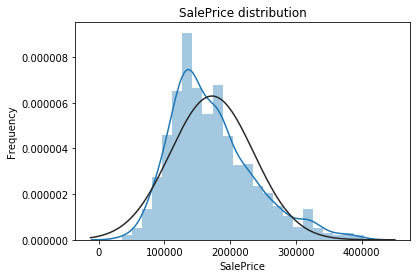

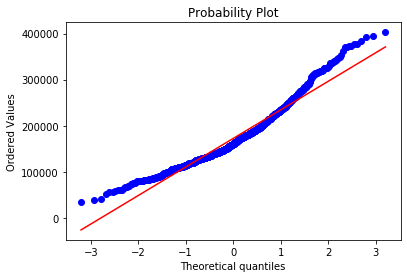

In [105]:
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew

#distplot
sns.distplot(train['SalePrice'] , fit=norm)

(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} \n sigma = {:.2f}\n'.format(mu, sigma))

plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#probplot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

### Log transformation of target variable, as it is right skewed


 mu = 11.99 
 sigma = 0.37



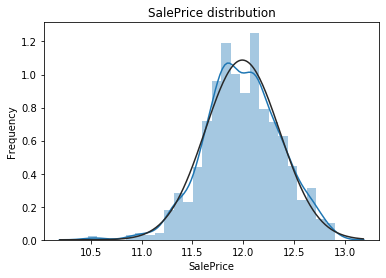

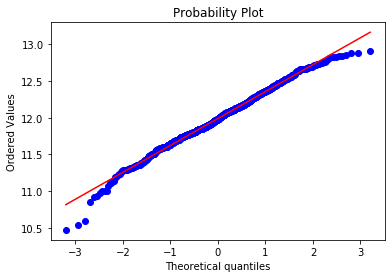

In [106]:
#log transform
train["SalePrice"] = np.log1p(train["SalePrice"])

#distplot
sns.distplot(train['SalePrice'] , fit=norm);

(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} \n sigma = {:.2f}\n'.format(mu, sigma))

plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#probplot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

### Skewed numerical features and Box Cox transformation

In [107]:
num_cols = list(train.select_dtypes(include=['float64','int64']).columns)
num_cols.remove('SalePrice')

# Check the skew of all numerical features
skewed_feats = train[num_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

,Skew
BsmtFinType2_ALQ,22.047321
BsmtFinType2_GLQ,21.900056
LowQualFinSF,16.413631
BsmtFinType2_BLQ,8.938417
BsmtFinType2_Rec,8.741559
BsmtFinType2_LwQ,8.139931
BsmtFinType1_LwQ,7.138941
BsmtFinType1_Rec,4.091781
BsmtFinType1_BLQ,3.723083
BsmtFinType1_ALQ,2.923060


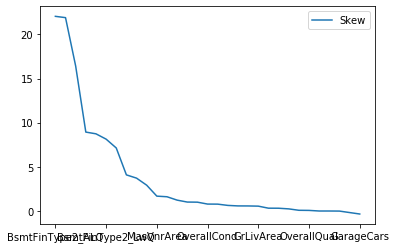

In [108]:
skewness.plot()

In [109]:
#Box Cox Transformation of (highly) skewed features
skewness = skewness[abs(skewness) > 0.75]
print(skewness.shape[0], 'skewed features')

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    train[feat] = boxcox1p(train[feat], lam)

31 skewed features


### 2.2.7 transforming rest of categorical to numerical

In [110]:
obj_cols = train.select_dtypes(include=['object']).columns
obj_cols

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive'],
      dtype='object')

In [111]:
for col in obj_cols:
    print(train[col].value_counts())
    print('null values: ',train[col].isnull().sum())
    print('----------')

RL         799
RM         149
FV          60
RH           9
C (all)      6
Name: MSZoning, dtype: int64
null values:  0
----------
Pave    1021
Grvl       2
Name: Street, dtype: int64
null values:  0
----------
Reg    669
IR1    331
IR2     18
IR3      5
Name: LotShape, dtype: int64
null values:  0
----------
Lvl    941
Bnk     37
HLS     32
Low     13
Name: LandContour, dtype: int64
null values:  0
----------
AllPub    1023
Name: Utilities, dtype: int64
null values:  0
----------
Inside     757
Corner     170
CulDSac     58
FR2         34
FR3          4
Name: LotConfig, dtype: int64
null values:  0
----------
Gtl    985
Mod     37
Sev      1
Name: LandSlope, dtype: int64
null values:  0
----------
NAmes      143
CollgCr    137
Somerst     78
Edwards     77
Gilbert     68
OldTown     63
Sawyer      52
NridgHt     52
NWAmes      42
SawyerW     42
BrkSide     40
Mitchel     32
Timber      28
Crawfor     28
IDOTRR      25
NoRidge     23
BrDale      15
MeadowV     15
StoneBr     15
Blmngtn

In [112]:
unique_vals = {}
for col in obj_cols:
    unique_vals[col] = len(train[col].unique())

for val in sorted(unique_vals, key=unique_vals.get, reverse=True):
    print(val, unique_vals[val])

Neighborhood 25
Exterior1st 13
Condition1 9
HouseStyle 7
Foundation 6
Functional 6
FireplaceQu 6
MSZoning 5
LotConfig 5
BldgType 5
RoofStyle 5
Heating 5
GarageType 5
GarageQual 5
GarageCond 5
LotShape 4
LandContour 4
RoofMatl 4
MasVnrType 4
ExterQual 4
BsmtQual 4
BsmtExposure 4
HeatingQC 4
Electrical 4
KitchenQual 4
LandSlope 3
Condition2 3
ExterCond 3
BsmtCond 3
GarageFinish 3
PavedDrive 3
Street 2
CentralAir 2
Utilities 1


Neighborhood will give a lot of extra columns, so let's drop it

In [113]:
train = train.drop('Neighborhood', axis = 1)
obj_cols = obj_cols.drop('Neighborhood')

#### Identify and drop columns in which a specific value is present in more than 90% of rows

In [114]:
cols_to_drop = []
for col in obj_cols:
    vls = train[col].value_counts(normalize=True)
    for i in range(len(vls)):
        if vls[i] > 0.9:
            cols_to_drop.append(col)
cols_to_drop

['Street',
 'LandContour',
 'Utilities',
 'LandSlope',
 'Condition2',
 'RoofMatl',
 'BsmtCond',
 'Heating',
 'CentralAir',
 'Electrical',
 'Functional',
 'GarageQual',
 'GarageCond',
 'PavedDrive']

In [115]:
train = train.drop(cols_to_drop, axis = 1)

In [116]:
obj_cols = train.select_dtypes(include=['object']).columns
obj_cols

Index(['MSZoning', 'LotShape', 'LotConfig', 'Condition1', 'BldgType',
       'HouseStyle', 'RoofStyle', 'Exterior1st', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtExposure', 'HeatingQC',
       'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish'],
      dtype='object')

#### Let's convert the rest of categorical columns to dummies

In [117]:
dummy_df = pd.get_dummies(train[obj_cols])
train = train.drop(obj_cols, axis = 1)
train = pd.concat([train, dummy_df], axis = 1)
train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,...,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf
0,60,5.831328,19.212182,2.440268,2.055642,8.059126,0.0,13.698888,1.540963,0.730463,...,0,0,1,0,0,0,0,0,1,0
2,60,5.914940,20.347241,2.440268,2.055642,7.646538,0.0,13.832085,1.540963,0.730463,...,0,1,1,0,0,0,0,0,1,0
4,60,6.314735,21.325160,2.602594,2.055642,9.391827,0.0,14.480029,1.820334,0.730463,...,0,1,1,0,0,0,0,0,1,0
6,20,6.098626,19.907529,2.602594,2.055642,7.944503,0.0,13.670207,1.540963,0.730463,...,0,0,1,0,0,0,0,0,1,0
10,20,5.968981,20.329199,2.055642,2.055642,0.000000,0.0,12.236143,1.540963,0.730463,...,0,0,0,0,0,0,1,0,0,1


#### rmse after all transformations: 17,659

In [118]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

features = train.columns.drop('SalePrice')

X, x, Y, y = train_test_split(train[features],train['SalePrice'], test_size = 0.2,random_state=1)


lr = LinearRegression()
lr.fit(X,Y)
predictions = lr.predict(x)

mse = mean_squared_error(predictions,y)
print('rmsle: ',mse**(1/2))

mse = mean_squared_error(np.expm1(predictions),np.expm1(y))
print('rmse: ', mse**(1/2))

rmsle:  0.1172272519113809
rmse:  17659.765916352477


# 3. Feature Selection

## 3.1 Collinearity with correlation

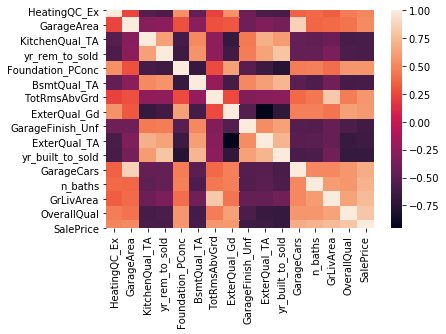

In [119]:
corrmat = train.corr()
sorted_corrs = corrmat['SalePrice'].abs().sort_values()

import seaborn as sns
strong_corrs = sorted_corrs[sorted_corrs > 0.5]
corrmat = train[strong_corrs.index].corr()
sns.heatmap(corrmat)

Columns that present collinearity:
GarageArea and GarageCars: drop GarageCars
TotRmsAbvGrd and GrLivArea: drop TotRmsAbvGrd

In [120]:
train = train.drop(['GarageCars','TotRmsAbvGrd'], axis = 1)

In [121]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

features = train.columns.drop('SalePrice')

X, x, Y, y = train_test_split(train[features],train['SalePrice'], test_size = 0.2,random_state=1)


lr = LinearRegression()
lr.fit(X,Y)
predictions = lr.predict(x)

mse = mean_squared_error(predictions,y)
print('rmsle: ',mse**(1/2))

mse = mean_squared_error(np.expm1(predictions),np.expm1(y))
print('rmse: ', mse**(1/2))

rmsle:  0.11631123317388531
rmse:  17561.09544173248


## 3.3 Low variance

In [44]:
# num_cols = list(train.select_dtypes(include=['float64','int64']).columns)
# num_cols.remove('SalePrice')

# X = (train[num_cols] - train[num_cols].min()) / (train[num_cols].max() - train[num_cols].min())
# col_vars = pd.DataFrame(columns=['col','var'])
# cols = []
# varsa = []
# for col in train[num_cols].columns:
#     cols.append(col)
#     varsa.append(X[col].var())
# col_vars['col'] = cols
# col_vars['var'] = varsa

# col_vars[col_vars['var'] < 0.001]

# low_var_cols = col_vars['col'][col_vars['var'] < 0.001]

# train = train.drop(low_var_cols, axis = 1)

#### rmse after dropping low variance cols: 17,473

In [45]:
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import train_test_split

# features = train.columns.drop('SalePrice')

# X, x, Y, y = train_test_split(train[features],train['SalePrice'], test_size = 0.2,random_state=1)


# lr = LinearRegression()
# lr.fit(X,Y)
# predictions = lr.predict(x)

# mse = mean_squared_error(predictions,y)
# print('rmsle: ',mse**(1/2))

# mse = mean_squared_error(np.expm1(predictions),np.expm1(y))
# print('rmse: ', mse**(1/2))

## 3.4 Best columns per correlation

In [122]:
best_feat = pd.DataFrame()

best_featur = []
best_rmse = []

def get_feat(cols):
    features = cols
    for i in range(len(cols)-1):
        X = train[features]
        corrs = train[cols].corr()['SalePrice'].abs().sort_values()
        
        feat = features.drop('SalePrice')

        X, x, Y, y = train_test_split(train[feat],train['SalePrice'], test_size = 0.2,random_state=1)

        lr = LinearRegression()
        lr.fit(X,Y)
        predictions = lr.predict(x)

        mse = mean_squared_error(predictions,y)

        best_rmse.append(mse**(1/2))
        best_featur.append(feat)
        
        if corrs.index[i] != 'SalePrice':
            features = features.drop(corrs.index[i])
            

cols = train.columns
get_feat(cols)
best_feat['feat'] = best_featur
best_feat['rmse'] = best_rmse

In [123]:
best_feat.sort_values(by='rmse',ascending=True).head()

,feat,rmse
38,"Index(['MSSubClass', 'LotFrontage', 'LotArea',...",0.112357
37,"Index(['MSSubClass', 'LotFrontage', 'LotArea',...",0.112406
33,"Index(['MSSubClass', 'LotFrontage', 'LotArea',...",0.112466
34,"Index(['MSSubClass', 'LotFrontage', 'LotArea',...",0.112466
36,"Index(['MSSubClass', 'LotFrontage', 'LotArea',...",0.112469


In [124]:
bf = best_feat.sort_values(by='rmse',ascending=True).iloc[0,0]#loc[17,'feat']

In [125]:
bf = pd.Series(bf)

#### rmse after correlation loop: 17,302

In [126]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

features = bf
X, x, Y, y = train_test_split(train[features],train['SalePrice'], test_size = 0.2,random_state=1)


lr = LinearRegression()
lr.fit(X,Y)
predictions = lr.predict(x)

mse = mean_squared_error(predictions,y)
print('rmsle: ',mse**(1/2))

mse = mean_squared_error(np.expm1(predictions),np.expm1(y))
print('rmse: ', mse**(1/2))

rmsle:  0.11235749317316283
rmse:  17302.61188761986


## 3.5 Applying RFECV

In [127]:
from sklearn.feature_selection import RFECV

features = bf
selector = RFECV(lr,cv=10)

X, x, Y, y = train_test_split(train[features],train['SalePrice'], test_size = 0.2,random_state=1)

selector.fit(X,Y)
best_columns = list(X.columns[selector.support_])

#### rmse after RFECV: 17,302 (no improvement)

In [128]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

features = best_columns
X, x, Y, y = train_test_split(train[features],train['SalePrice'], test_size = 0.2,random_state=1)


lr = LinearRegression()
lr.fit(X,Y)
predictions = lr.predict(x)

mse = mean_squared_error(predictions,y)
print('rmsle: ',mse**(1/2))

mse = mean_squared_error(np.expm1(predictions),np.expm1(y))
print('rmse: ', mse**(1/2))

rmsle:  0.11235749317316283
rmse:  17302.61188761981


** Note: applying RFECV before the correlation selection didn't get better results in this case

# Modelling, averaging, stacking

In [129]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [130]:
import warnings
def ignore_warn(*args, **kwargs):
    pass                                                      
warnings.warn = ignore_warn

In [131]:
features = list(features)
features.remove('MSSubClass')

In [133]:
def rmse_cv(model):
    n_folds = 5
    kf = KFold(n_folds, shuffle=True, random_state=0).get_n_splits(train)
    rmse = -cross_val_score(model, train[features], train['SalePrice'], scoring = 'neg_root_mean_squared_error', cv = kf)
    return rmse

In [134]:
lr = LinearRegression()
score = rmse_cv(lr)
print("\nLinearRegression score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


LinearRegression score: 0.1292 (0.0124)



In [135]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmse_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1116 (0.0057)



In [136]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score = rmse_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1116 (0.0055)



In [137]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score = rmse_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1235 (0.0097)



In [138]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
score = rmse_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1175 (0.0094)



In [139]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
score = rmse_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1185 (0.0051)



In [140]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

score = rmse_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1221 (0.0093)



In [141]:
#Copypaste of averaging models class
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [144]:
averaged_models = AveragingModels(models = (ENet, GBoost, lasso)) #picking best performing

score = rmse_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1082 (0.0062)



# 3. Making predictions

In [145]:
def clean(df):
    cols_to_drop = ["MoSold", "SaleCondition", "SaleType", "YrSold", 'GarageYrBlt','YearBuilt','YearRemodAdd']
    df['yr_built_to_sold'] = df['YrSold'] - df['YearBuilt']
    df['yr_rem_to_sold'] = df['YrSold'] - df['YearRemodAdd']
    df['MSSubClass'] = df['MSSubClass'].astype('category')
    df = df.drop(cols_to_drop, axis=1)

    nul_cols = (df.isnull().sum())

    #drop columns that contain null values in their majority
    df = df.drop(['Alley','PoolQC','Fence','MiscFeature'], axis=1)
    
    #handling null values
    nul_cols = (df.isnull().sum())

    cols_to_fix = nul_cols[nul_cols > 0]

    object_cols = df[cols_to_fix.index].select_dtypes(include=['object']).columns

    object_cols = object_cols.drop('FireplaceQu')
    for col in object_cols:
        mode = df[col].mode()
        df[col] = df[col].fillna(mode.iloc[0])
    
    df['FireplaceQu'] = df['FireplaceQu'].fillna('NA')
    num_cols = df[cols_to_fix.index].select_dtypes(include=['float64']).columns

    for col in num_cols:
        mode = df[col].mode()
        df[col] = df[col].fillna(mode.iloc[0])
    return df

    
    
    
def transform(df):
    df['n_floors'] = df['2ndFlrSF'].apply(lambda x: 2 if x > 0 else 1)
    df = df.drop(['1stFlrSF','2ndFlrSF'], axis=1)
    
    bath_cols = ['BsmtFullBath','FullBath','BsmtHalfBath','HalfBath']
    df['n_baths'] = df['BsmtFullBath'] + df['FullBath'] + (df['BsmtHalfBath']/2) + (df['HalfBath']/2)

    df = df.drop(bath_cols, axis=1)

    porch_cols = ['OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']

    df['porch_area'] = df[porch_cols].sum(axis=1)
    df = df.drop(porch_cols, axis=1)

    misc_cols = ['MiscVal'] #miscfeature was already dropped
    df = df.drop(misc_cols,axis=1)
    df = df.drop('Exterior2nd', axis = 1)


    bsmnt_cols = ['BsmtFinType1','BsmtFinType2','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']
    bsm_dum = pd.get_dummies(df[bsmnt_cols])

    type1 = ['BsmtFinType1_ALQ', 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ',
       'BsmtFinType1_LwQ', 'BsmtFinType1_Rec', 'BsmtFinType1_Unf']
    type2 = ['BsmtFinType2_ALQ', 'BsmtFinType2_BLQ', 'BsmtFinType2_GLQ',
       'BsmtFinType2_LwQ', 'BsmtFinType2_Rec', 'BsmtFinType2_Unf']

    for i in range(len(bsm_dum)):
        for col in type1:
            if bsm_dum[col].iloc[i] == 1:
                bsm_dum[col].iloc[i] = bsm_dum['BsmtFinSF1'].iloc[i]
        for col in type2:
            if bsm_dum[col].iloc[i] == 1:
                bsm_dum[col].iloc[i] = bsm_dum['BsmtFinSF2'].iloc[i]
            
    bsmnt_drop = ['BsmtFinSF1','BsmtFinSF2','TotalBsmtSF','BsmtFinType1_Unf','BsmtFinType2_Unf']
    df = df.drop(bsmnt_cols, axis = 1)
    df = pd.concat([df, bsm_dum], axis = 1)
    df = df.drop(bsmnt_drop, axis=1)
    num_cols = df.select_dtypes(include=['float64','int64','int32']).columns

    cols_to_drop = ['Street',
     'LandContour',
     'Utilities',
     'LandSlope',
     'Condition2',
     'RoofMatl',
     'BsmtCond',
     'Heating',
     'CentralAir',
     'Electrical',
     'Functional',
     'GarageQual',
     'GarageCond',
     'PavedDrive']

    df = df.drop(cols_to_drop, axis = 1)

    obj_cols = df.select_dtypes(include=['object']).columns

    dummy_df = pd.get_dummies(df[obj_cols])
    df = df.drop(obj_cols, axis = 1)
    df = pd.concat([df, dummy_df], axis = 1)
    return df

In [146]:
test = pd.read_csv('test.csv')

In [147]:
test = clean(test) 

In [148]:
test_cl = transform(test)
test_cl['FireplaceQu_NA'] = 0

In [149]:
for feat in skewed_features:
    test_cl[feat] = boxcox1p(test_cl[feat], lam)

In [151]:
test_cl = test_cl.replace(np.nan,0)
test_cl = test_cl.replace(np.inf, 1)

In [152]:
averaged_models.fit(train[bf],train['SalePrice'])
predictions = averaged_models.predict(test_cl[bf])

In [153]:
predictions

array([11.67968181, 12.00063283, 12.13280853, ..., 12.02891117,
       11.64859678, 12.27684156])

In [154]:
test_cl['SalePrice'] = np.expm1(predictions)

In [155]:
test_cl[['Id','SalePrice']].to_csv('sub3.csv', index=False)